In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf",
                                         from_type="gemma",
                                         load_eager=True
                                         )

In [4]:
!mkdir -p data
import pandas as pd
df_adv = pd.read_csv("data/adv.csv")
format_prompt = """<start_of_turn>user\n
{}\n
<start_of_turn>model\n
{}"""
# offset = 1
# df_do = df.apply(lambda x: format_response.format(x['goal'], x['target']), axis=1)
# prompts_harmful = df.apply(lambda x: format_prompt.format(x['goal'], "")[:-offset], axis=1).to_list()[:100]
prompts_harmful = df_adv.apply(lambda x: format_prompt.format(x['goal'], ""), axis=1).to_list()[:100]
dataset_jail = pd.read_csv("data/jail.csv").apply(lambda x: x["Goal"], axis=1).to_list()
prompts_jail = [format_prompt.format(x, "") for x in dataset_jail]
import datasets
# https://colab.research.google.com/drive/1a-aQvKC9avdZpdyBn4jgRQFObTPy1JZw
hf_path = 'tatsu-lab/alpaca'
dataset = datasets.load_dataset(hf_path)
# filter for instructions that do not have inputs
prompts_harmless = []
for i in range(len(dataset['train'])):
    if len(prompts_harmless) >= len(prompts_harmful):
        break
    if dataset['train'][i]['input'].strip() == '':
        # prompts_harmless.append(format_prompt.format(dataset['train'][i]['instruction'], "")[:-offset])
        prompts_harmless.append(format_prompt.format(dataset['train'][i]['instruction'], ""))

# ds = datasets.load_dataset("MBZUAI/LaMini-instruction", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     prompts_harmless.append(format_prompt.format(text["instruction"], ""))

# ds = datasets.load_dataset("nev/openhermes-2.5-phi-format-text", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     text = text["text"]
#     text = "".join(text.partition("<|assistant|>\n")[:2])
#     prompts_harmless.append(text)

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [6]:
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
import jax

tokens = tokenizer.batch_encode_plus(prompts_harmful + prompts_harmless,
                                     return_tensors="np",
                                     padding="max_length",
                                     truncation=True,
                                     max_length=128,
                                     return_attention_mask=True)
token_array = jnp.asarray(tokens["input_ids"])
token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")
inputs = llama.inputs.from_basic_segments(token_array)

In [7]:
from micrlhf.llama import LlamaBlock
from micrlhf.flash import flashify
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)
_, resids = get_resids_call(inputs)

/tmp/ipykernel_3844145/4119513429.py:13: RuntimeWarning: invalid value encountered in divide
  residiff = residiff / np.linalg.norm(residiff)


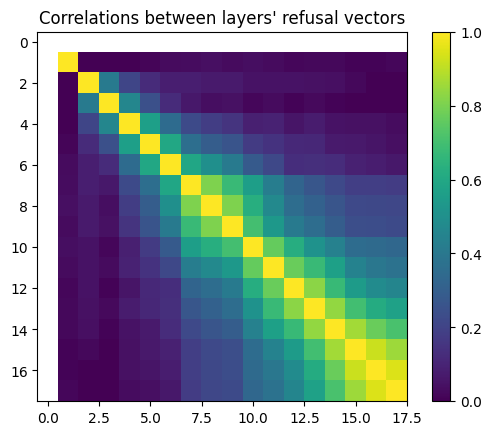

In [8]:
from matplotlib import pyplot as plt
import numpy as np
residiffs = []
last_resids = []
for i, resid in enumerate(sorted(resids, key=lambda x: int(x.tag.rpartition("_")[-1]))):
    resid = resid.value.unwrap("batch", "seq", "embedding")
    indices = jnp.asarray(tokens["attention_mask"].sum(1, keepdims=True))[..., None] - 1
    last_resid = jnp.take_along_axis(resid, indices, 1)[:, 0]
    last_resid = last_resid.reshape(2, -1, last_resid.shape[-1])
    last_resids.append(last_resid)
    last_resid = last_resid.mean(1)
    residiff = np.array(last_resid[0] - last_resid[1])
    residiff = residiff / np.linalg.norm(residiff)
    residiffs.append(residiff)
matmuls = np.matmul(residiffs, np.transpose(residiffs))
norms = np.linalg.norm(residiffs, axis=-1) + 1e-10
plt.title("Correlations between layers' refusal vectors")
plt.imshow(matmuls / norms[:, None] / norms[None, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [15]:
from micrlhf.utils.vector_storage import save_and_upload_vector, download_vector
from micrlhf.utils.load_sae import get_nev_it_sae_suite
from micrlhf.utils.ito import grad_pursuit


sae_k = 4
for layer_sae in range(8, 16):
    dictionary = get_nev_it_sae_suite(layer_sae)["W_dec"]
    for layer in range(0, len(residiffs)):
        vector_name = f"gemma-refusal-l{layer}"
        vector = residiffs[layer]
        save_and_upload_vector(vector_name, vector, overwrite=True)
        weights, recon = grad_pursuit(vector, dictionary, sae_k, pos_only=True)
        _, i = jax.lax.top_k(jnp.abs(weights), sae_k)
        print(f"Layer {layer} -> Layer {layer_sae}: {i}")
    print()

Layer 0 -> Layer 8: [0 1 2 3]
Layer 1 -> Layer 8: [27309 26633 21572 12555]
Layer 2 -> Layer 8: [17441 20897 26059  2745]
Layer 3 -> Layer 8: [30549  3823 23130 31749]
Layer 4 -> Layer 8: [ 6688  7975 25926 14616]
Layer 5 -> Layer 8: [26817 25855 23130  8847]
Layer 6 -> Layer 8: [26817  6688 15337  9412]
Layer 7 -> Layer 8: [17050  2161 28044 29985]
Layer 8 -> Layer 8: [ 8286 17050 29985 19254]
Layer 9 -> Layer 8: [ 8286 29985  6688 26408]
Layer 10 -> Layer 8: [ 8286  7180 19254     0]
Layer 11 -> Layer 8: [ 8286 27334 24403 13282]
Layer 12 -> Layer 8: [27334 20363 22416  4797]
Layer 13 -> Layer 8: [11727 20363 26878 24403]
Layer 14 -> Layer 8: [17534 26878 14872 19712]
Layer 15 -> Layer 8: [17534  6721 26239 14872]
Layer 16 -> Layer 8: [ 6024 27944 27373 13282]
Layer 17 -> Layer 8: [18910 27944 26239  1391]

Layer 0 -> Layer 9: [0 1 2 3]
Layer 1 -> Layer 9: [13951 11654 14285 20998]
Layer 2 -> Layer 9: [11858 10675  6156 28947]
Layer 3 -> Layer 9: [17183 16398 19266  9492]
Layer 4 -> 

HfHubHTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/models/kisate-team/micrlhf/commit/main (Request ID: Root=1-6696ff36-7608bd995b9dd1066e9f1c8e;2702f8be-8ede-4e76-befd-6d193ea79266)

You have been rate-limited; you can retry this action in about 1 hour. If you're a new user, your limits will raise progressively over time. Get in touch with us at website@huggingface.co if you need access now.